In [1]:
import gc
import os
import math
import numpy as np
import pandas as pd
from numba import njit
from numpy import sqrt, sin, cos, pi, zeros
from numpy.random import randn, rand, uniform, normal
from scipy.linalg import hadamard
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Activation, LSTM, Dropout, RepeatVector, TimeDistributed, Embedding, Reshape, Dot, Concatenate
from tensorflow.keras.layers import GRU, SpatialDropout1D, Conv1D, GlobalMaxPooling1D,Multiply, Lambda, Softmax, Flatten, BatchNormalization, Bidirectional, dot, concatenate
from tensorflow.keras.layers import AdditiveAttention, Attention
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from tensorflow.keras import backend
from tensorflow.keras.metrics import MeanSquaredError
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import requests
from helpers import ILottoCSV
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.get_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
tf.config.optimizer.set_jit(True)

Tensorflow version 2.3.4
REPLICAS:  1


In [2]:
orig_lotto_csv = "input/Orig_IL_lotto.csv"
lotto_csv_file = "input/lotto_IL_filtered.csv"
csv_url = "https://pais.co.il/Lotto/lotto_resultsDownload.aspx"
base_dir = os.path.dirname(orig_lotto_csv)
if not os.path.exists(base_dir):
    os.makedirs(base_dir)
r = requests.get(csv_url)
with open(orig_lotto_csv,'wb') as f:
    f.write(r.content)
ILottoCSV(orig_lotto_csv, lotto_csv_file)

lotto = pd.read_csv(lotto_csv_file, index_col = 'Date')
print(lotto)

            Ball_1  Ball_2  Ball_3  Ball_4  Ball_5  Ball_6  Ball_Bonus
Date                                                                  
24/01/2023       3      16      20      28      34      36           3
21/01/2023       6       7       9      18      21      31           7
17/01/2023       1       5       9      12      18      36           6
14/01/2023       4       5       9      18      19      35           2
10/01/2023       1      26      28      31      34      36           3
...            ...     ...     ...     ...     ...     ...         ...
29/10/1968       3       9      26      32      34      36           1
15/10/1968       1       6      23      29      33      34           7
08/10/1968       7       9      10      17      23      34           4
01/10/1968       1       7       8       9      11      30           4
03/09/1968       3      14      18      22      25      33           2

[2072 rows x 7 columns]


In [3]:
data = lotto.values - 1
train = data[50:]
test = data[:50]

w = 10
X_train = []
y_train = []
for i in range(w, len(train)):
    X_train.append(train[i - w: i, :])
    y_train.append(train[i])

X_train, y_train = np.array(X_train), np.array(y_train)
inputs = data[data.shape[0] - test.shape[0] - w:]
X_test = []
for i in range(w, inputs.shape[0]):
    X_test.append(inputs[i - w: i, :])
X_test = np.array(X_test)
y_test = test

In [4]:
print(data.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2072, 7)
(2012, 10, 7)
(2012, 7)
(50, 10, 7)
(50, 7)


In [5]:
numbers = 37
embed_dim = 30
dropout_rate = 0.5
spatial_dropout_rate = 0.5
steps_before = w
steps_after = 7
feature_count = embed_dim * 7
hidden_neurons = [64, 32] 
bidirectional = True 
attention_style = 'Bahdanau'

In [6]:
with strategy.scope():
    
    inp0 = Input(shape = (w, X_train.shape[2]))
    
    # Embed numbers categories into a 30-dimension continuous-number vector for each ball
    inp1 = Lambda(lambda x: x[:, :, 0])(inp0)
    inp1 = Embedding(numbers, embed_dim)(inp1)
    inp1 = SpatialDropout1D(spatial_dropout_rate)(inp1)
    
    inp2 = Lambda(lambda x: x[:, :, 1])(inp0)
    inp2 = Embedding(numbers, embed_dim)(inp2)
    inp2 = SpatialDropout1D(spatial_dropout_rate)(inp2)
    
    inp3 = Lambda(lambda x: x[:, :, 2])(inp0)
    inp3 = Embedding(numbers, embed_dim)(inp3)
    inp3 = SpatialDropout1D(spatial_dropout_rate)(inp3)
    
    inp4 = Lambda(lambda x: x[:, :, 3])(inp0)
    inp4 = Embedding(numbers, embed_dim)(inp4)
    inp4 = SpatialDropout1D(spatial_dropout_rate)(inp4)
    
    inp5 = Lambda(lambda x: x[:, :, 4])(inp0)
    inp5 = Embedding(numbers, embed_dim)(inp5)
    inp5 = SpatialDropout1D(spatial_dropout_rate)(inp5)    
    
    inp6 = Lambda(lambda x: x[:, :, 5])(inp0)
    inp6 = Embedding(numbers, embed_dim)(inp6)
    inp6 = SpatialDropout1D(spatial_dropout_rate)(inp6)
    
    inp7 = Lambda(lambda x: x[:, :, 6])(inp0)
    inp7 = Embedding(numbers, embed_dim)(inp7)
    inp7 = SpatialDropout1D(spatial_dropout_rate)(inp7)
    
    inp = Concatenate()([inp1, inp2, inp3, inp4, inp5, inp6, inp7])
    
    # Seq2Seq model with attention or bidirectional encoder
    
    num_layers = len(hidden_neurons)
    
    sh_list, h_list, c_list = [inp], [], []
    
    if bidirectional:
        
        for i in range(num_layers):
    
            sh, fh, fc, bh, bc = Bidirectional(LSTM(hidden_neurons[i],
                                                    dropout = dropout_rate, 
                                                    return_state = True, 
                                                    return_sequences = True))(sh_list[-1])
        
            h = Concatenate()([fh, bh])
            c = Concatenate()([fc, bc]) 

            sh_list.append(sh)
            h_list.append(h)
            c_list.append(c)
        
    else:
    
        for i in range(num_layers):

            sh, h, c = LSTM(hidden_neurons[i], 
                            dropout = dropout_rate,
                            return_state = True, 
                            return_sequences = True)(sh_list[-1])

            sh_list.append(sh)
            h_list.append(h)
            c_list.append(c)
    
    decoder = RepeatVector(steps_after)(h_list[-1])
    
    if bidirectional:
        
        decoder_hidden_neurons = [hn * 2 for hn in hidden_neurons]
        
    else:
        
        decoder_hidden_neurons = hidden_neurons
    
    for i in range(num_layers):
        
        decoder = LSTM(decoder_hidden_neurons[i],
                       dropout = dropout_rate, 
                       return_sequences = True)(decoder, initial_state = [h_list[i], c_list[i]])
       
    if attention_style == 'Bahdanau':
        
        context = AdditiveAttention(dropout = dropout_rate)([decoder, sh_list[-1]])
        
        decoder = concatenate([context, decoder])
        
    elif attention_style == 'Luong':
        
        context = Attention(dropout = dropout_rate)([decoder, sh_list[-1]])
        
        decoder = concatenate([context, decoder])
    
    out = Dense(numbers, activation = 'softmax')(decoder)

    model = Model(inputs = inp0, outputs = out)
    
    sparse_top_k = tf.keras.metrics.SparseTopKCategoricalAccuracy(k = 5, name = 'sparse_top_k')

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = [sparse_top_k])

In [7]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 7)]      0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 10)           0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 10)           0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 10)           0           input_1[0][0]                    
_______________________________________________________________________________________

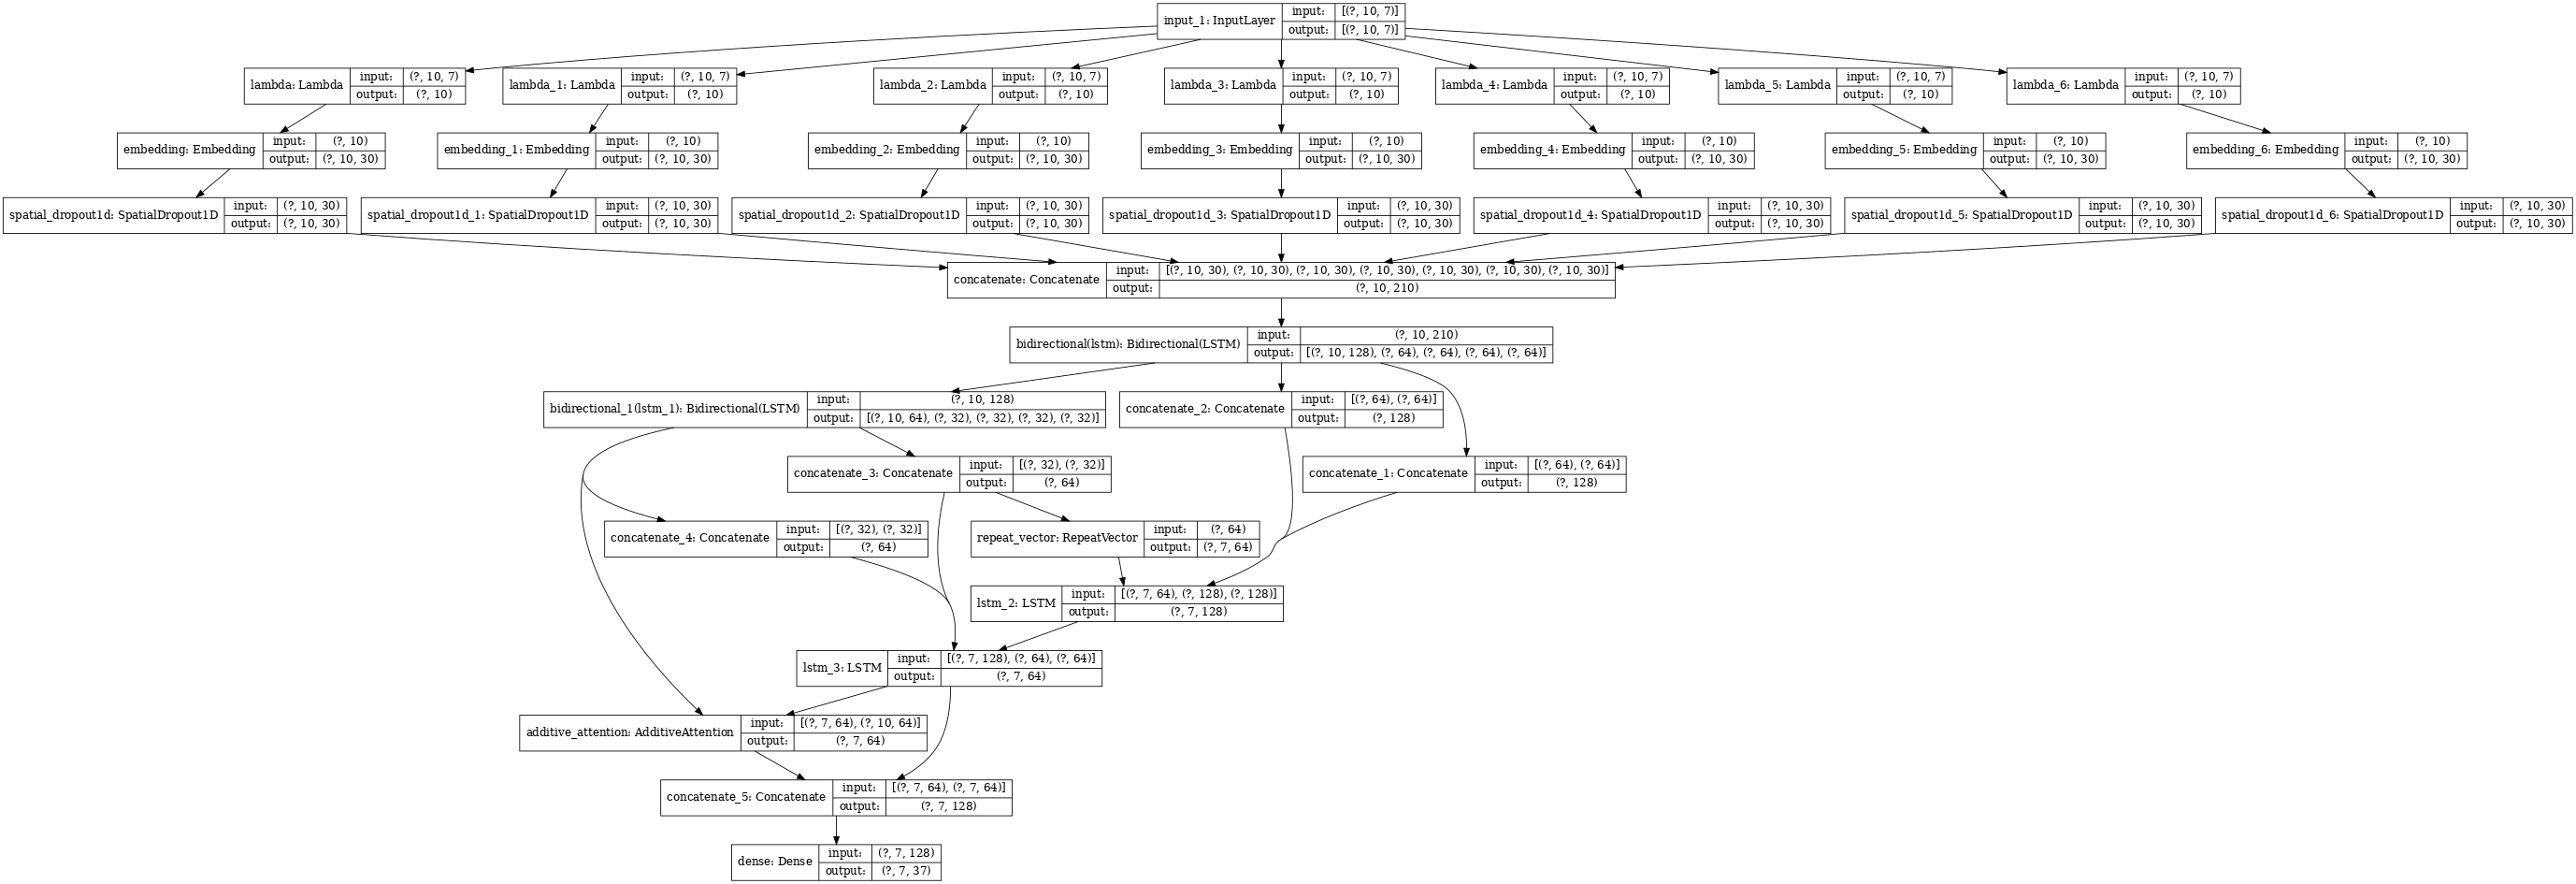

In [8]:
plot_model(model, show_shapes = True, show_layer_names = True, rankdir = 'TB', dpi = 60)


In [9]:
class CosineAnnealingScheduler(callbacks.Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, T_max, eta_max, eta_min = 0, verbose = 0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs = None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        backend.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs = None):
        logs = logs or {}
        logs['lr'] = backend.get_value(self.model.optimizer.lr)

In [10]:
EPOCHS = 250
BATCH_SIZE = 32
LR_MAX = 1e-4
LR_MIN = 1e-5

cas = CosineAnnealingScheduler(EPOCHS, LR_MAX, LR_MIN)

ckp = callbacks.ModelCheckpoint('best_model.hdf5', monitor = 'val_sparse_top_k', verbose = 0, 
                                save_best_only = True, save_weights_only = False, mode = 'max')

history = model.fit(X_train, y_train, 
                    validation_data = (X_test, y_test), 
                    callbacks = [ckp, cas], 
                    epochs = EPOCHS, 
                    batch_size = BATCH_SIZE, 
                    verbose = 2)

hist = pd.DataFrame(history.history)

Epoch 1/250
63/63 - 5s - loss: 3.6083 - sparse_top_k: 0.1727 - val_loss: 3.6045 - val_sparse_top_k: 0.2200
Epoch 2/250
63/63 - 2s - loss: 3.5957 - sparse_top_k: 0.2100 - val_loss: 3.5783 - val_sparse_top_k: 0.2200
Epoch 3/250
63/63 - 2s - loss: 3.5334 - sparse_top_k: 0.2160 - val_loss: 3.4801 - val_sparse_top_k: 0.2200
Epoch 4/250
63/63 - 2s - loss: 3.3956 - sparse_top_k: 0.2329 - val_loss: 3.2848 - val_sparse_top_k: 0.2886
Epoch 5/250
63/63 - 2s - loss: 3.2324 - sparse_top_k: 0.3392 - val_loss: 3.1442 - val_sparse_top_k: 0.3514
Epoch 6/250
63/63 - 2s - loss: 3.1253 - sparse_top_k: 0.3787 - val_loss: 3.0528 - val_sparse_top_k: 0.3886
Epoch 7/250
63/63 - 2s - loss: 3.0528 - sparse_top_k: 0.4036 - val_loss: 2.9832 - val_sparse_top_k: 0.4343
Epoch 8/250
63/63 - 2s - loss: 3.0059 - sparse_top_k: 0.4179 - val_loss: 2.9489 - val_sparse_top_k: 0.4371
Epoch 9/250
63/63 - 2s - loss: 2.9748 - sparse_top_k: 0.4299 - val_loss: 2.9174 - val_sparse_top_k: 0.4400
Epoch 10/250
63/63 - 2s - loss: 2.948

0.46000000834465027


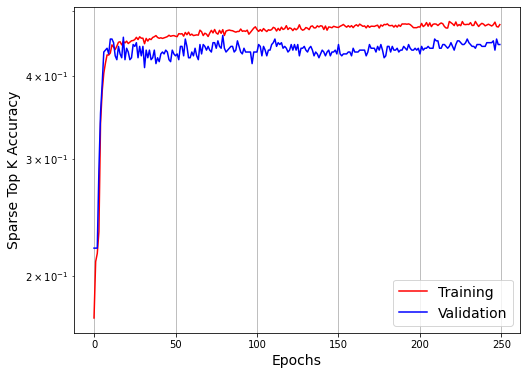

In [11]:
print(hist['val_sparse_top_k'].max())

plt.figure(figsize = (8, 6))
plt.semilogy(hist['sparse_top_k'], '-r', label = 'Training')
plt.semilogy(hist['val_sparse_top_k'], '-b', label = 'Validation')
plt.ylabel('Sparse Top K Accuracy', fontsize = 14)
plt.xlabel('Epochs', fontsize = 14)
plt.legend(fontsize = 14)
plt.grid()
plt.show()

In [12]:
model.load_weights('best_model.hdf5')
pred = model.predict(X_test)
pred = np.argmax(pred, axis = 2)

In [13]:
for i in range(y_test.shape[0]):
    print('Prediction:\t', pred[i] + 1)
    print('GoundTruth:\t', y_test[i] + 1)
    print('-' * 40)

Prediction:	 [ 1  8 17 24 28 37  3]
GoundTruth:	 [ 3 16 20 28 34 36  3]
----------------------------------------
Prediction:	 [ 1  9 17 23 28 37  3]
GoundTruth:	 [ 6  7  9 18 21 31  7]
----------------------------------------
Prediction:	 [ 1 11 21 23 32 37  3]
GoundTruth:	 [ 1  5  9 12 18 36  6]
----------------------------------------
Prediction:	 [ 2 12 21 28 34 37  3]
GoundTruth:	 [ 4  5  9 18 19 35  2]
----------------------------------------
Prediction:	 [ 1  9 17 23 28 37  3]
GoundTruth:	 [ 1 26 28 31 34 36  3]
----------------------------------------
Prediction:	 [ 1  8 17 23 28 37  3]
GoundTruth:	 [10 14 17 20 31 36  5]
----------------------------------------
Prediction:	 [ 1  8 17 23 28 37  3]
GoundTruth:	 [ 2  6 29 30 31 32  2]
----------------------------------------
Prediction:	 [ 1  8 17 24 28 37  3]
GoundTruth:	 [ 4  8 17 20 24 32  3]
----------------------------------------
Prediction:	 [ 1  8 17 23 28 37  3]
GoundTruth:	 [ 6  7 14 27 31 32  6]
------------------------

In [14]:
# beam search
def beam_search_decoder(data, k, replace = True):
    sequences = [[list(), 0.0]]
    # walk over each step in sequence
    for row in data:
        all_candidates = list()
        # expand each current candidate
        for i in range(len(sequences)):
            seq, score = sequences[i]
            best_k = np.argsort(row)[-k:]
            for j in best_k:
                candidate = [seq + [j], score + math.log(row[j])]
                if replace:
                    all_candidates.append(candidate)
                elif (replace == False) and (len(set(candidate[0])) == len(candidate[0])):
                    all_candidates.append(candidate)
        # order all candidates by score
        ordered = sorted(all_candidates, key = lambda tup:tup[1], reverse = True)
        # select k best
        sequences = ordered[:k]
    return sequences

In [15]:
X_latest = X_test[0][1:]
X_latest = np.concatenate([X_latest, y_test[0].reshape(1, 7)], axis = 0)
X_latest = X_latest.reshape(1, X_latest.shape[0], X_latest.shape[1])
print(X_latest + 1)

[[[ 1  7 18 23 26 31  4]
  [ 4  8 15 24 29 30  7]
  [11 16 28 29 31 35  3]
  [ 5  7 19 26 32 33  6]
  [ 8 18 25 29 32 35  2]
  [ 5 13 30 33 34 36  3]
  [ 5  6 26 27 30 32  2]
  [17 22 27 33 34 35  2]
  [ 7 12 15 22 28 33  6]
  [ 3 16 20 28 34 36  3]]]


In [16]:
pred_latest = model.predict(X_latest)
pred_latest = np.squeeze(pred_latest)
pred_latest_greedy = np.argmax(pred_latest, axis = 1)
print(pred_latest_greedy + 1)

[ 1  8 17 23 28 37  3]


In [17]:
beam_width = 10
replace = True

result = beam_search_decoder(pred_latest, beam_width, replace)
print('Beam Width:\t', beam_width)
print('Replace:\t', replace)
print('-' * 85)
for seq in result:
    print('Prediction: ', np.array(seq[0]) + 1, '\tLog Likelihood: ', seq[1])

Beam Width:	 10
Replace:	 True
-------------------------------------------------------------------------------------
Prediction:  [ 1  8 17 23 28 37  3] 	Log Likelihood:  -16.02650325967299
Prediction:  [ 1  8 17 24 28 37  3] 	Log Likelihood:  -16.03012074898406
Prediction:  [ 1  9 17 23 28 37  3] 	Log Likelihood:  -16.03317232155231
Prediction:  [ 1  9 17 24 28 37  3] 	Log Likelihood:  -16.036789810863382
Prediction:  [ 1  8 21 23 28 37  3] 	Log Likelihood:  -16.052064236763766
Prediction:  [ 1  8 21 24 28 37  3] 	Log Likelihood:  -16.055681726074834
Prediction:  [ 1  9 21 23 28 37  3] 	Log Likelihood:  -16.058733298643087
Prediction:  [ 1  8 18 23 28 37  3] 	Log Likelihood:  -16.059128069068052
Prediction:  [ 1  9 21 24 28 37  3] 	Log Likelihood:  -16.062350787954156
Prediction:  [ 1  8 18 24 28 37  3] 	Log Likelihood:  -16.062745558379124


In [18]:
beam_width = 10
replace = False

result = beam_search_decoder(pred_latest, beam_width, replace)
print('Beam Width:\t', beam_width)
print('Replace:\t', replace)
print('-' * 85)
for seq in result:
    print('Prediction: ', np.array(seq[0]) + 1, '\tLog Likelihood: ', seq[1])

Beam Width:	 10
Replace:	 False
-------------------------------------------------------------------------------------
Prediction:  [ 1  8 17 23 28 37  3] 	Log Likelihood:  -16.02650325967299
Prediction:  [ 1  8 17 24 28 37  3] 	Log Likelihood:  -16.03012074898406
Prediction:  [ 1  9 17 23 28 37  3] 	Log Likelihood:  -16.03317232155231
Prediction:  [ 1  9 17 24 28 37  3] 	Log Likelihood:  -16.036789810863382
Prediction:  [ 1  8 21 23 28 37  3] 	Log Likelihood:  -16.052064236763766
Prediction:  [ 1  8 21 24 28 37  3] 	Log Likelihood:  -16.055681726074834
Prediction:  [ 1  9 21 23 28 37  3] 	Log Likelihood:  -16.058733298643087
Prediction:  [ 1  8 18 23 28 37  3] 	Log Likelihood:  -16.059128069068052
Prediction:  [ 1  9 21 24 28 37  3] 	Log Likelihood:  -16.062350787954156
Prediction:  [ 1  8 18 24 28 37  3] 	Log Likelihood:  -16.062745558379124
